In [12]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

print(nx.drawing.layout.__file__)

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\layout.py


In [13]:
# Import data

dataset = 'asset_class' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('%s_corr.npy' % (dataset))
dates = np.load('%s_dates.npy' % (dataset))
nodes = np.load('%s_nodes.npy' % (dataset))
nodes_descr = np.load('%s_nodes_descr.npy' % (dataset))

num_examples = corr_tensor.shape[0] #number of dates
dim = corr_tensor.shape[1] #number of asset

In [14]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

In [15]:
# source code for DWave Structural Imbalance algorithm - modified to include timing


from dwave_networkx.utils import binary_quadratic_model_sampler
from dwave_networkx import _PY2


__all__ = ["structural_imbalance"]


# compatibility for python 2/3

if _PY2:
    def iteritems(d): return d.iteritems()
else:
    def iteritems(d): return d.items()


@binary_quadratic_model_sampler(1)

def structural_imbalance(S, sampler=None, **sampler_args):

    h, J = structural_imbalance_ising(S)

    # use the sampler to find low energy states
    response = sampler.sample_ising(h, J, **sampler_args)
    computation_time = response.info['timing']['qpu_access_time'] / 10**6 #compute qpu access time, and convert to seconds 

    # we want the lowest energy sample
    sample = next(iter(response))

    # spins determine the color
    colors = {v: (spin + 1) // 2 for v, spin in iteritems(sample)}

    # frustrated edges are the ones that are violated
    frustrated_edges = {}
    for u, v, data in S.edges(data=True):
        sign = data['sign']

        if sign > 0 and colors[u] != colors[v]:
            frustrated_edges[(u, v)] = data
        elif sign < 0 and colors[u] == colors[v]:
            frustrated_edges[(u, v)] = data

        # else: not frustrated or sign == 0, no relation to violate
    return frustrated_edges, colors, computation_time


def structural_imbalance_ising(S):

    h = {v: 0.0 for v in S}
    J = {}
    for u, v, data in S.edges(data=True):
        try:
            J[(u, v)] = -1. * data['sign']
        except KeyError:
            raise ValueError(("graph should be a signed social graph,"
                              "each edge should have a 'sign' attr"))

    return h, J

In [16]:
corr_mat = corr_tensor[30, :, :].copy()
        
corr_mat[(corr_mat > -1*0.7) & (corr_mat < 0.7)] = 0
G, density = make_graph(corr_mat, nodes, 'signed')

In [17]:
G.edges(data=True)

EdgeDataView([('BND', 'RWR', {'sign': -1}), ('BND', 'SHY', {'sign': 1}), ('BND', 'TLT', {'sign': 1}), ('BND', 'VB', {'sign': -1}), ('BND', 'VO', {'sign': -1}), ('BND', 'VTI', {'sign': -1}), ('DBB', 'VWO', {'sign': 1}), ('DBE', 'SLV', {'sign': 1}), ('DBE', 'USO', {'sign': 1}), ('DBE', 'VB', {'sign': 1}), ('DBE', 'VO', {'sign': 1}), ('GLD', 'SLV', {'sign': 1}), ('ICF', 'RWR', {'sign': 1}), ('ICF', 'USRT', {'sign': 1}), ('ICF', 'VB', {'sign': 1}), ('ICF', 'VEU', {'sign': 1}), ('ICF', 'VO', {'sign': 1}), ('ICF', 'VTI', {'sign': 1}), ('ICF', 'VWO', {'sign': 1}), ('RWR', 'USRT', {'sign': 1}), ('RWR', 'VB', {'sign': 1}), ('RWR', 'VEU', {'sign': 1}), ('RWR', 'VO', {'sign': 1}), ('RWR', 'VTI', {'sign': 1}), ('RWR', 'VWO', {'sign': 1}), ('SLV', 'USO', {'sign': 1}), ('USO', 'VB', {'sign': 1}), ('USO', 'VO', {'sign': 1}), ('USO', 'VTI', {'sign': 1}), ('USRT', 'VB', {'sign': 1}), ('USRT', 'VO', {'sign': 1}), ('USRT', 'VTI', {'sign': 1}), ('VB', 'VEU', {'sign': 1}), ('VB', 'VO', {'sign': 1}), ('VB',

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


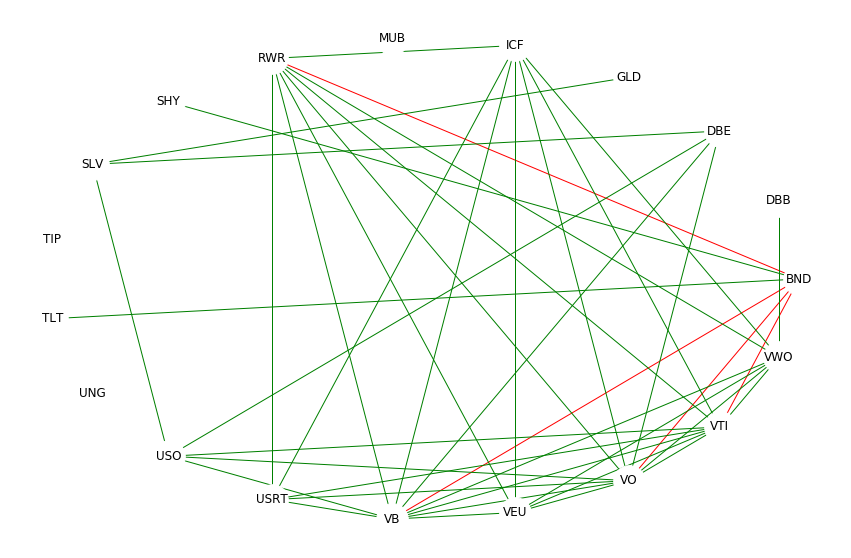

In [18]:
edge_cols = []
for edge in G.edges(data=True):
    if edge[2]["sign"] == -1:
        edge_cols.append("red")
    else:
        edge_cols.append("green")
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, node_color="white", 
              edge_color=edge_cols)

In [19]:
# Test to see if DW comp. is working
imbalance, bicoloring, computation_time = structural_imbalance(G, sampler)
frustration_score = len(list(imbalance.keys()))/G.number_of_edges()

In [20]:
imbalance

{}

In [21]:
frustration_score

0.0

In [22]:
bicoloring

{'BND': 0,
 'DBB': 1,
 'DBE': 1,
 'GLD': 1,
 'ICF': 1,
 'MUB': 1,
 'RWR': 1,
 'SHY': 0,
 'SLV': 1,
 'TIP': 1,
 'TLT': 0,
 'UNG': 0,
 'USO': 1,
 'USRT': 1,
 'VB': 1,
 'VEU': 1,
 'VO': 1,
 'VTI': 1,
 'VWO': 1}

In [23]:
new_bicoloring = {}
nodes_one = []
for node, color in bicoloring.items():
    if color == 1:
        nodes_one.append(node)

In [24]:
nodes_one

['DBB',
 'DBE',
 'GLD',
 'ICF',
 'MUB',
 'RWR',
 'SLV',
 'TIP',
 'USO',
 'USRT',
 'VB',
 'VEU',
 'VO',
 'VTI',
 'VWO']

In [25]:
#DELETE THIS CELL IF WE FIGURE OUT THE BUG WITH nx.drawing.layout.bipartite_layout

def _process_params(G, center, dim):
    # Some boilerplate code.
    import numpy as np

    if not isinstance(G, nx.Graph):
        empty_graph = nx.Graph()
        empty_graph.add_nodes_from(G)
        G = empty_graph

    if center is None:
        center = np.zeros(dim)
    else:
        center = np.asarray(center)

    if len(center) != dim:
        msg = "length of center coordinates must match dimension of layout"
        raise ValueError(msg)

    return G, center

def rescale_layout(pos, scale=1):
    # Find max length over all dimensions
    lim = 0  # max coordinate for all axes
    for i in range(pos.shape[1]):
        pos[:, i] -= pos[:, i].mean()
        lim = max(abs(pos[:, i]).max(), lim)
    # rescale to (-scale, scale) in all directions, preserves aspect
    if lim > 0:
        for i in range(pos.shape[1]):
            pos[:, i] *= scale / lim
    return pos


def bipartite_layout(G, nodes, align='vertical',
                     scale=1, center=None, aspect_ratio=4/3):


    import numpy as np

    G, center = _process_params(G, center=center, dim=2)
    if len(G) == 0:
        return {}

    height = 1
    width = aspect_ratio * height
    offset = (width/2, height/2)

    top = set(nodes)
    bottom = set(G) - top
    nodes = list(top) + list(bottom)

    if align == 'vertical':
        left_xs = np.repeat(0, len(top))
        right_xs = np.repeat(width, len(bottom))
        left_ys = np.linspace(0, height, len(top))
        right_ys = np.linspace(0, height, len(bottom))

        top_pos = np.column_stack([left_xs, left_ys]) - offset
        bottom_pos = np.column_stack([right_xs, right_ys]) - offset

        pos = np.concatenate([top_pos, bottom_pos])
        pos = rescale_layout(pos, scale=scale) + center
        pos = dict(zip(nodes, pos))
        return pos

    if align == 'horizontal':
        top_ys = np.repeat(height, len(top))
        bottom_ys = np.repeat(0, len(bottom))
        top_xs = np.linspace(0, width, len(top))
        bottom_xs = np.linspace(0, width, len(bottom))

        top_pos = np.column_stack([top_xs, top_ys]) - offset
        bottom_pos = np.column_stack([bottom_xs, bottom_ys]) - offset

        pos = np.concatenate([top_pos, bottom_pos])
        pos = rescale_layout(pos, scale=scale) + center
        pos = dict(zip(nodes, pos))
        return pos

    msg = 'align must be either vertical or horizontal.'
    raise ValueError(msg)


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


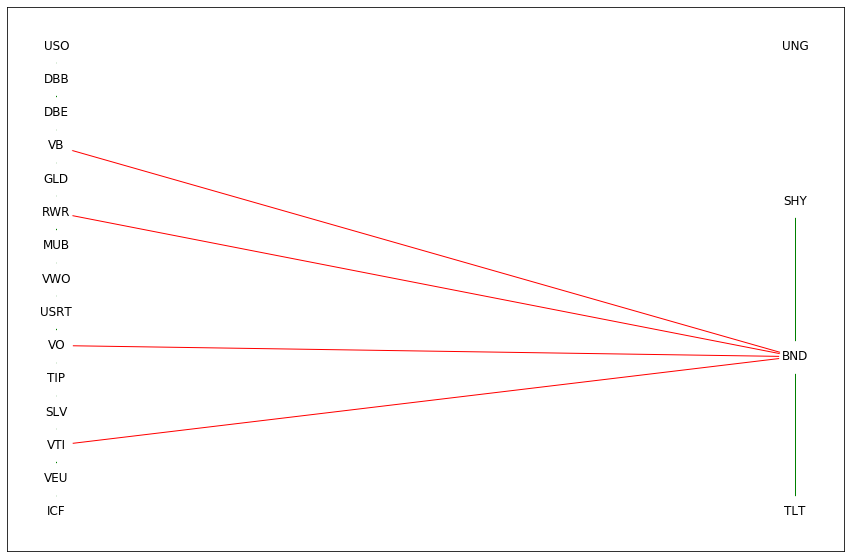

In [26]:
edge_cols = []
frustrated_edges = imbalance.keys()
for edge in G.edges(data=True):
    if (edge[0],edge[1]) in frustrated_edges:
        edge_cols.append("black")
    elif edge[2]["sign"] == -1:
        edge_cols.append("red")
    else:
        edge_cols.append("green")

fig,ax = plt.subplots(figsize=(15,10))
nx.draw_networkx(G, pos=bipartite_layout(G, nodes_one), ax=ax, 
                 with_labels=True, node_size=1000, node_color="white", edge_color=edge_cols)

In [27]:
G.edges

EdgeView([('BND', 'RWR'), ('BND', 'SHY'), ('BND', 'TLT'), ('BND', 'VB'), ('BND', 'VO'), ('BND', 'VTI'), ('DBB', 'VWO'), ('DBE', 'SLV'), ('DBE', 'USO'), ('DBE', 'VB'), ('DBE', 'VO'), ('GLD', 'SLV'), ('ICF', 'RWR'), ('ICF', 'USRT'), ('ICF', 'VB'), ('ICF', 'VEU'), ('ICF', 'VO'), ('ICF', 'VTI'), ('ICF', 'VWO'), ('RWR', 'USRT'), ('RWR', 'VB'), ('RWR', 'VEU'), ('RWR', 'VO'), ('RWR', 'VTI'), ('RWR', 'VWO'), ('SLV', 'USO'), ('USO', 'VB'), ('USO', 'VO'), ('USO', 'VTI'), ('USRT', 'VB'), ('USRT', 'VO'), ('USRT', 'VTI'), ('VB', 'VEU'), ('VB', 'VO'), ('VB', 'VTI'), ('VB', 'VWO'), ('VEU', 'VO'), ('VEU', 'VTI'), ('VEU', 'VWO'), ('VO', 'VTI'), ('VO', 'VWO'), ('VTI', 'VWO')])

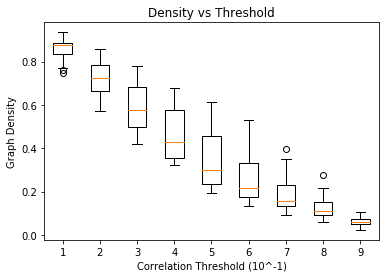

In [28]:

# Plot graph density for each threshold. 
thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'signed')
        
        density_array.append(density)
    
    density_distr.append(density_array)

plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("Density vs Threshold")
plt.show()

In [29]:

# Create graph for each month and calculate frustration. 

frustration_array = []
bicoloring_array = []
date_array = []
density_array = []
threshold_array = []
time_array = []

count = 0
for i in np.arange(0.1, 1, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'signed')

        try:
            opt_imbalance, opt_bicoloring, comp_time = structural_imbalance(G, sampler)
            opt_score = len(list(imbalance.keys()))/G.number_of_edges()
            
            if opt_score > 0.00:
                for k in range(3):
                    imbalance, bicoloring, comp_time_temp = structural_imbalance(G, sampler)
                    frustration_score = len(list(imbalance.keys()))/G.number_of_edges()
                    
                    if frustration_score < opt_score:
                        opt_imbalance = imbalance
                        opt_bicoloring = bicoloring
                        opt_score = frustration_score
                        comp_time = comp_time_temp
                        
            count += 1
            
            if count % 10 == 0:
                print("iteration: i = %f, j = %d" % (i,j))
                
        except Exception as err:
            print(err)
            print("No soln found for threshold %f and matrix %d" % (i, int(j*5)))
        else:
            threshold_array.append(i)
            frustration_array.append(opt_score)
            bicoloring_array.append(opt_bicoloring)
            density_array.append(density)
            date_array.append(dates[j*5])
            time_array.append(comp_time)

iteration: i = 0.100000, j = 10
iteration: i = 0.100000, j = 20
iteration: i = 0.200000, j = 7
iteration: i = 0.200000, j = 17
iteration: i = 0.300000, j = 4
iteration: i = 0.300000, j = 14
iteration: i = 0.400000, j = 1
iteration: i = 0.400000, j = 11
iteration: i = 0.400000, j = 21
iteration: i = 0.500000, j = 8
iteration: i = 0.500000, j = 18
iteration: i = 0.600000, j = 5
iteration: i = 0.600000, j = 15
iteration: i = 0.700000, j = 2
iteration: i = 0.700000, j = 12
iteration: i = 0.700000, j = 22
iteration: i = 0.800000, j = 9
iteration: i = 0.800000, j = 19
iteration: i = 0.900000, j = 6
iteration: i = 0.900000, j = 16


In [30]:
assert len(frustration_array) == len(date_array) == len(density_array) == len(threshold_array) == len(time_array)

In [31]:
# Create Pandas DataFrame for results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array, 
                   "frustration_score": frustration_array, 
                   "bicoloring": bicoloring_array, "computation_time": time_array}).to_csv("structbal_quant_%s_res.csv" % (dataset))

In [32]:
import multiprocessing
from gurobipy import *

indset_array = []
valid_soln_array = []
frustration_array = []
density_array = []
time_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')
    
    G_classical = nx.convert_node_labels_to_integers(G)

    signedMatrix = nx.to_numpy_matrix(G_classical,weight='sign')
    unsignedMatrix = abs(signedMatrix)

    weighted_edges = nx.get_edge_attributes(G_classical, 'sign') 
    
    sorted_weighted_edges={}
    for (u,v) in weighted_edges:
        if u<v:
            (sorted_weighted_edges)[(u,v)] = weighted_edges[(u,v)]
        if u>v:
            (sorted_weighted_edges)[(v,u)] = weighted_edges[(u,v)]

    
    try:    
        
        order=len(signedMatrix)
        NumberOfNegative=((-1 == signedMatrix)).sum()/2
        size=int(np.count_nonzero(signedMatrix)/2)

        neighbors={}
        Degree=[]
        for u in sorted((G_classical).nodes()):
            neighbors[u] = list((G_classical)[u])
            Degree.append(len(neighbors[u]))
        unsignedDegree=Degree

        #fixing node is based on unsigned degree
        maximum_degree = max(unsignedDegree)
        [node_to_fix]=[([i for i, j in enumerate(unsignedDegree) if j == maximum_degree]).pop()]

        # Model parameters
        model = Model("UBQP")
        model.setParam(GRB.Param.Threads, multiprocessing.cpu_count())     


        # Create decision variables and update model to integrate new variables
        x=[]
        for i in range(0,order):
            x.append(model.addVar(vtype=GRB.BINARY, name='x'+str(i))) # arguments by name
        model.update()

        # Set the objective function
        OFV=0
        for (i,j) in (sorted_weighted_edges):
            OFV = OFV + (1-(sorted_weighted_edges)[(i,j)])/2 + \
            ((sorted_weighted_edges)[(i,j)])*(x[i]+x[j]-2*x[i]*x[j]) 
        model.setObjective(OFV, GRB.MINIMIZE)

        # Add constraints to the model and update model to integrate new constraints
        model.addConstr(x[node_to_fix]==1)
        model.update() 

        # Solve
        start_time = time.time()
        model.optimize()
        solveTime = time.time() - start_time 


        # Save optimal objective function values
        obj = model.getObjective()
        objectivevalue = obj.getValue()

    except Exception as err:
        print(err)
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        frustration_array.append(objectivevalue)
        density_array.append(density)
        #bicoloring_array.append(opt_bicoloring)
        time_array.append(solveTime)


Academic license - for non-commercial use only
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+0


Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1

  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
B

   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.00000


Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statis

  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of paramete

Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.13 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available pro

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Fou

Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 contin

  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, 

Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations


Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range  

Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution foun

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Fou

Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 contin

  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 1 rows, 19 columns and 1 nonzeros
Variable types: 0 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, 

In [33]:
# Create Pandas DataFrame for results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array, 
                   "frustration_score": frustration_array, 
                   "bicoloring": bicoloring_array, "computation_time": time_array}).to_csv("structbal_class_%s_res.csv" % (dataset))